In [1]:
import numpy as np
import pandas as pd
import glob
import pandas_profiling
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


#### INSTNM 
Instituition name



#### HIGHDEG
Highest degree that students most consistently earn



#### CONTROL
Doesn't explicitly say this, but assumed
1 = public
2 = private, non-profit
3 = private, for-profit



#### REGION
Region school is located



#### LOCALE
Distinguishes between
1 = city
2 = suburb
3 = town
4 = rural area

subcategories for cities and suburbs:
1 = large (250k or more in population)
2 = mid (between 100k and 250k in pop)
3 = small (< 100k)

subcatergories for towns:
1 = fringe (up to 10 miles from urbanized area)
2 = distant (10-35 miles)
3 = remote (>35 miles)

subcategories for rural:
1 = fringe (up to 5 miles from urbanized area or 2.5 miles from urbanized cluster)
2 = distant(5-25 from urbanized area or 2.5-10 " " " " " " " )
3 = remote (more than 25 or more than 10 """""")



#### CURROPER
Whether or not the school is currently operating



#### TUITFTE
Tuition revenue minus discounts and allowances. Divides this by the number of full-time enrolled (FTE) undergrad + grad students



#### INEXPFTE
Instructional expenditures divided by the number of FTE students



#### CDR3
This is the three-year cohort default rate. The rate at which a cohort defaults on loans 3 years after graduating.
Cohort default rates are produced annually32 as an institutional accountability metric; institutions with high default rates may lose access to federal financial aid. 



#### LO_INC_DEBT_N
The number of students in the median debt with low income (<= 30k)
How much the students took out in order to go to school.



#### MD_INC_DEBT_N
(30k< income <= 75k)



#### HI_INC_DEBT_N
(> 75k)



#### ICLEVEL
Highest degree offered by institution (not the highest one commonly earned like HIGHDEG is).



#### year
The year


In [6]:
# Read in data
df = pd.read_pickle('pickle_copy.pkl')

In [7]:
# Check out the df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154228 entries, 0 to 7057
Data columns (total 14 columns):
INSTNM           154228 non-null object
HIGHDEG          154228 non-null int64
CONTROL          154205 non-null float64
REGION           154227 non-null float64
LOCALE           6614 non-null float64
CURROPER         7058 non-null float64
TUITFTE          133780 non-null float64
INEXPFTE         133775 non-null float64
CDR3             47815 non-null float64
LO_INC_DEBT_N    137486 non-null object
MD_INC_DEBT_N    137486 non-null object
HI_INC_DEBT_N    137486 non-null object
ICLEVEL          154205 non-null float64
year             154228 non-null int64
dtypes: float64(8), int64(2), object(4)
memory usage: 17.6+ MB


In [10]:
df.head() # Looking at the head

,INSTNM,HIGHDEG,CONTROL,REGION,LOCALE,CURROPER,TUITFTE,INEXPFTE,CDR3,LO_INC_DEBT_N,MD_INC_DEBT_N,HI_INC_DEBT_N,ICLEVEL,year
0,Community College of the Air Force,2,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1996
1,Alabama A & M University,4,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1996
2,University of Alabama at Birmingham,4,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1996
3,ALABAMA AVIATION AND TECHNICAL COLLEGE,2,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1996
4,Amridge University,4,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1996


In [8]:
df['TUITFTE'].value_counts().sort_index() # Problem. A lot of outliers in the millions.

0.0           727
1.0             3
2.0             6
3.0             5
4.0             4
             ... 
6523168.0       1
7014195.0       1
8969462.0       1
11932462.0      1
26670163.0      1
Name: TUITFTE, Length: 26398, dtype: int64

In [13]:
df['TUITFTE'].median() #median tuition

6457.0

In [73]:
df[df['year']==1998]['TUITFTE'].isna().sum()

20448

In [17]:
# Dropping low count columns
df_dropped_missing = df.drop(['LOCALE', 'CURROPER', 'CDR3' ], axis=1)

In [18]:
# Dropping na values
df_no_nan = df_dropped_missing.dropna()

In [19]:
df_no_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125104 entries, 0 to 6736
Data columns (total 11 columns):
INSTNM           125104 non-null object
HIGHDEG          125104 non-null int64
CONTROL          125104 non-null float64
REGION           125104 non-null float64
TUITFTE          125104 non-null float64
INEXPFTE         125104 non-null float64
LO_INC_DEBT_N    125104 non-null object
MD_INC_DEBT_N    125104 non-null object
HI_INC_DEBT_N    125104 non-null object
ICLEVEL          125104 non-null float64
year             125104 non-null int64
dtypes: float64(5), int64(2), object(4)
memory usage: 11.5+ MB


In [20]:
# Observing data count per year
df_no_nan['year'].value_counts().sort_index()

1998    6051
1999    5939
2000    5574
2001    5953
2002    6273
2003    6375
2004    6321
2005    6416
2006    6439
2007    6457
2008    6561
2009    6732
2010    7010
2011    7254
2012    7341
2013    7340
2014    7244
2015    7112
2016    6712
Name: year, dtype: int64

In [21]:
# shape of df
df_no_nan.shape

(125104, 11)

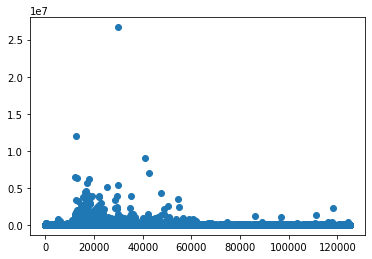

In [77]:
# Observing distribution of tuition
tuition_df = df_no_nan[df_no_nan['year']>=1998]

plt.scatter(np.arange(0, len(tuition_df)), tuition_df['TUITFTE'])

In [25]:
# Observing the top most expensive schools in the data set
tuition_df[tuition_df['TUITFTE']> tuition_df['TUITFTE'].quantile(0.9999)].groupby(['INSTNM'])['TUITFTE'].mean().sort_values(ascending=False)

INSTNM
Brooks College                                             26670163.0
San Joaquin Valley College-Visalia                         11932462.0
Everest University-Lakeland                                 8969462.0
University of Phoenix-Central Valley Campus                 7014195.0
Platt College-Arizona Automotive Institute Arizona          6523168.0
Lake Forest Graduate School of Management                   6395326.0
Le Cordon Bleu College of Culinary Arts-San Francisco       6194095.0
Le Cordon Bleu College of Culinary Arts-Pasadena            5603339.0
Antioch University-PhD Program in Leadership and Change     5438695.0
Remington College-New Orleans Campus                        5060030.0
Star Career Academy-Brick                                   4530500.0
Maranatha Baptist University                                4388630.0
Name: TUITFTE, dtype: float64

In [78]:
# Getting rid of outliers by taking the 99th percentile for tuition
tuition99_df = tuition_df[tuition_df['TUITFTE'] <= tuition_df['TUITFTE'].quantile(0.99)]

plt.scatter(np.arange(0, len(tuition99_df)), tuition99_df['TUITFTE'])

In [80]:
tuition_time_series_data = tuition99_df.groupby('year').TUITFTE.mean()
tuition_time_series_data

# Eliminating outliers and observing the mean for each year. There is an upward trend by year.

year
1998     5342.203867
1999     5580.027293
2000     6477.983327
2001     6623.589044
2002     6296.431429
2003     6301.234593
2004     6705.994899
2005     7052.610502
2006     7496.571183
2007     7728.497579
2008     7891.385404
2009     8057.406818
2010     8453.926418
2011     8971.184807
2012     9394.091890
2013     9807.837451
2014    10053.892931
2015    10222.695548
2016    10272.102074
Name: TUITFTE, dtype: float64

In [81]:
# Just checking out what else you can do. .agg aggregates all the specified values (in list)
tuition_agg_df = tuition99_df.groupby('year').TUITFTE.agg(['mean', 'median', 'min' , 'max', 'count'])
tuition_agg_df

,mean,median,min,max,count
year,,,,,
1998,5342.203867,3807.0,0.0,60902.0,5999
1999,5580.027293,3946.0,0.0,60886.0,5899
2000,6477.983327,4150.5,0.0,61464.0,5158
2001,6623.589044,4307.0,0.0,61902.0,5677
2002,6296.431429,4182.0,0.0,61792.0,6198
2003,6301.234593,4276.0,0.0,60592.0,6296
2004,6705.994899,4938.0,0.0,60462.0,6273
2005,7052.610502,5273.5,0.0,61287.0,6380
2006,7496.571183,5612.0,0.0,61881.0,6399


In [82]:
all_agg_df = tuition99_df.groupby('year').agg(['mean', 'median', 'min' , 'max', 'count'])
all_agg_df

HIGHDEG                        CONTROL                         ...  \
          mean median min max count      mean median  min  max count  ...   
year                                                                  ...   
1998  2.268711      2   0   4  5999  2.015336    2.0  1.0  3.0  5999  ...   
1999  2.308018      2   0   4  5899  2.020681    2.0  1.0  3.0  5899  ...   
2000  2.456185      2   0   4  5158  1.929624    2.0  1.0  3.0  5158  ...   
2001  2.392461      2   0   4  5677  1.996125    2.0  1.0  3.0  5677  ...   
2002  2.313004      2   0   4  6198  2.035657    2.0  1.0  3.0  6198  ...   
2003  2.304956      2   0   4  6296  2.054161    2.0  1.0  3.0  6296  ...   
2004  2.300654      2   0   4  6273  2.064403    2.0  1.0  3.0  6273  ...   
2005  2.308150      2   0   4  6380  2.082132    2.0  1.0  3.0  6380  ...   
2006  2.303485      2   0   4  6399  2.096890    2.0  1.0  3.0  6399  ...   
2007  2.335573      2   0   4  6401  2.103421    2.0  1.0  3.0  6401  ...   
2008  2.324051      2   0   4  6536  2.122552    2.0  1.0  3.0  6536  ...   
2009  2.309616      2   0   4  6718  2.140667    2.0  1.0  3.0  6718  ...   
2010  2.282898      2   0   4  6999  2.169881    2.0  1.0  3.0  6999  ...   
2011  2.278453      2   0   4  7240  2.194890    2.0  1.0  3.0  7240  ...   
2012  2.302567      2   0   4  7324  2.201393    2.0  1.0  3.0  7324  ...   
2013  2.313225      2   0   4  7327  2.199263    2.0  1.0  3.0  7327  ...   
2014  2.325495      2   0   4  7229  2.197261    2.0  1.0  3.0  7229  ...   
2015  2.344181      2   0   4  7098  2.176529    2.0  1.0  3.0  7098  ...   
2016  2.372034      2   0   4  6701  2.132965    2.0  1.0  3.0  6701  ...   

          INEXPFTE                                 ICLEVEL                   \
              mean  median  min        max count      mean median  min  max   
year                                                                          
1998   5250.386731  3165.0  0.0  2471694.0  5999  1.864644    2.0  1.0  3.0   
1999   5531.184269  3319.0  0.0  3391496.0  5899  1.850992    2.0  1.0  3.0   
2000  10750.986041  3806.5  0.0  5584280.0  5158  1.752811    2.0  1.0  3.0   
2001  10197.075920  3798.0  0.0  7784547.0  5677  1.805179    2.0  1.0  3.0   
2002   7896.347370  3750.0  0.0  2625394.0  6198  1.862859    2.0  1.0  3.0   
2003   7341.611499  3667.5  0.0  1398167.0  6296  1.859276    2.0  1.0  3.0   
2004   8195.205484  3752.0  0.0  5080198.0  6273  1.853818    2.0  1.0  3.0   
2005   6916.811755  3980.5  0.0  1198196.0  6380  1.850940    2.0  1.0  3.0   
2006   7005.991249  4215.0  0.0  1239550.0  6399  1.852477    2.0  1.0  3.0   
2007   6827.731761  4439.0  0.0   817237.0  6401  1.837682    2.0  1.0  3.0   
2008   6702.742197  4533.0  0.0  2422164.0  6536  1.840575    2.0  1.0  3.0   
2009   6180.047782  4489.5  0.0   594211.0  6718  1.847425    2.0  1.0  3.0   
2010   6118.896271  4435.0  0.0   269489.0  6999  1.857980    2.0  1.0  3.0   
2011   6200.091022  4515.5  0.0   267531.0  7240  1.861326    2.0  1.0  3.0   
2012   6498.047652  4834.5  0.0   274954.0  7324  1.853359    2.0  1.0  3.0   
2013   6843.040262  5191.0  0.0   307089.0  7327  1.851099    2.0  1.0  3.0   
2014   7167.306958  5479.0  0.0   357489.0  7229  1.855028    2.0  1.0  3.0   
2015   7421.731192  5645.0  0.0   393969.0  7098  1.848549    2.0  1.0  3.0   
2016   7799.120430  5746.0  0.0   794825.0  6701  1.838382    2.0  1.0  3.0   

            
     count  
year        
1998  5999  
1999  5899  
2000  5158  
2001  5677  
2002  6198  
2003  6296  
2004  6273  
2005  6380  
2006  6399  
2007  6401  
2008  6536  
2009  6718  
2010  6999  
2011  7240  
2012  7324  
2013  7327  
2014  7229  
2015  7098  
2016  6701  

[19 rows x 30 columns]

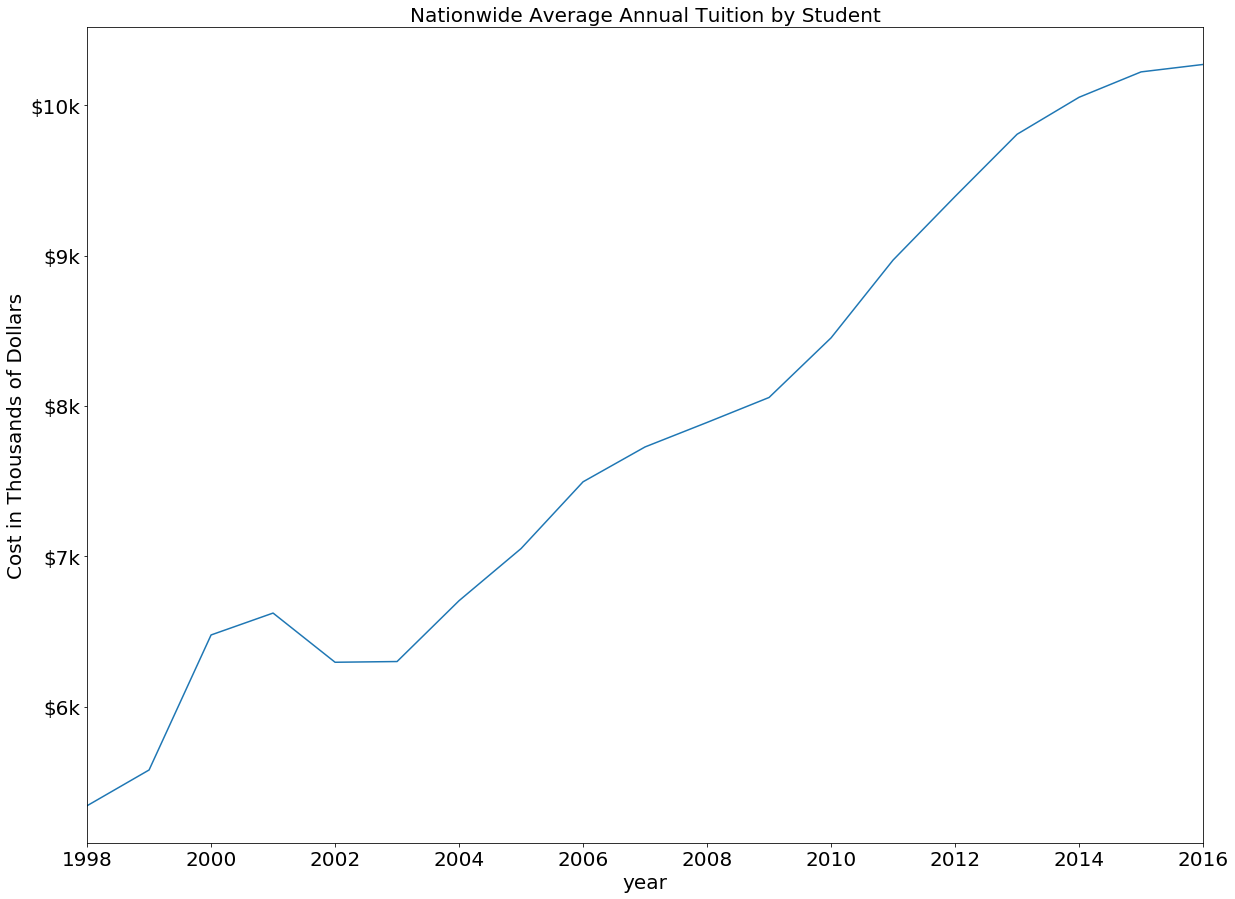

In [83]:
# Plotting the mean tuition by year

fig = plt.figure(figsize=(20,15))
plt.title('Nationwide Average Annual Tuition by Student', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Cost in Thousands of Dollars', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([6000, 7000, 8000, 9000, 10000], ['$6k', '$7k', '$8k', '$9k', '$10k'], fontsize=20)
tuition_time_series_data.plot()



In [84]:
# Redoing the dataframe with a timeseries index to make the data stationary
tuition_time_series_df = pd.DataFrame([tuition_time_series_data.index, tuition_time_series_data.values])

In [85]:
tuition_time_series_df = tuition_time_series_df.T

In [86]:
tuition_time_series_df.columns = ['Year', 'Avg Cost per Student']

In [87]:
tuition_time_series_df['Year'] = tuition_time_series_df['Year'].astype(int)

In [88]:
tuition_time_series_df['Avg Cost per Student'] = round(tuition_time_series_df['Avg Cost per Student'], 2)

In [89]:
tuition_time_series_df

,Year,Avg Cost per Student
0,1998,5342.20
1,1999,5580.03
2,2000,6477.98
3,2001,6623.59
4,2002,6296.43
5,2003,6301.23
6,2004,6705.99
7,2005,7052.61
8,2006,7496.57
9,2007,7728.50


In [90]:
tuition_time_series_df.index = pd.to_datetime(tuition_time_series_df['Year'], format='%Y')

tuition_time_series_df.drop('Year', inplace=True, axis=1 )


In [91]:
tuition_time_series_df

,Avg Cost per Student
Year,
1998-01-01,5342.20
1999-01-01,5580.03
2000-01-01,6477.98
2001-01-01,6623.59
2002-01-01,6296.43
2003-01-01,6301.23
2004-01-01,6705.99
2005-01-01,7052.61
2006-01-01,7496.57


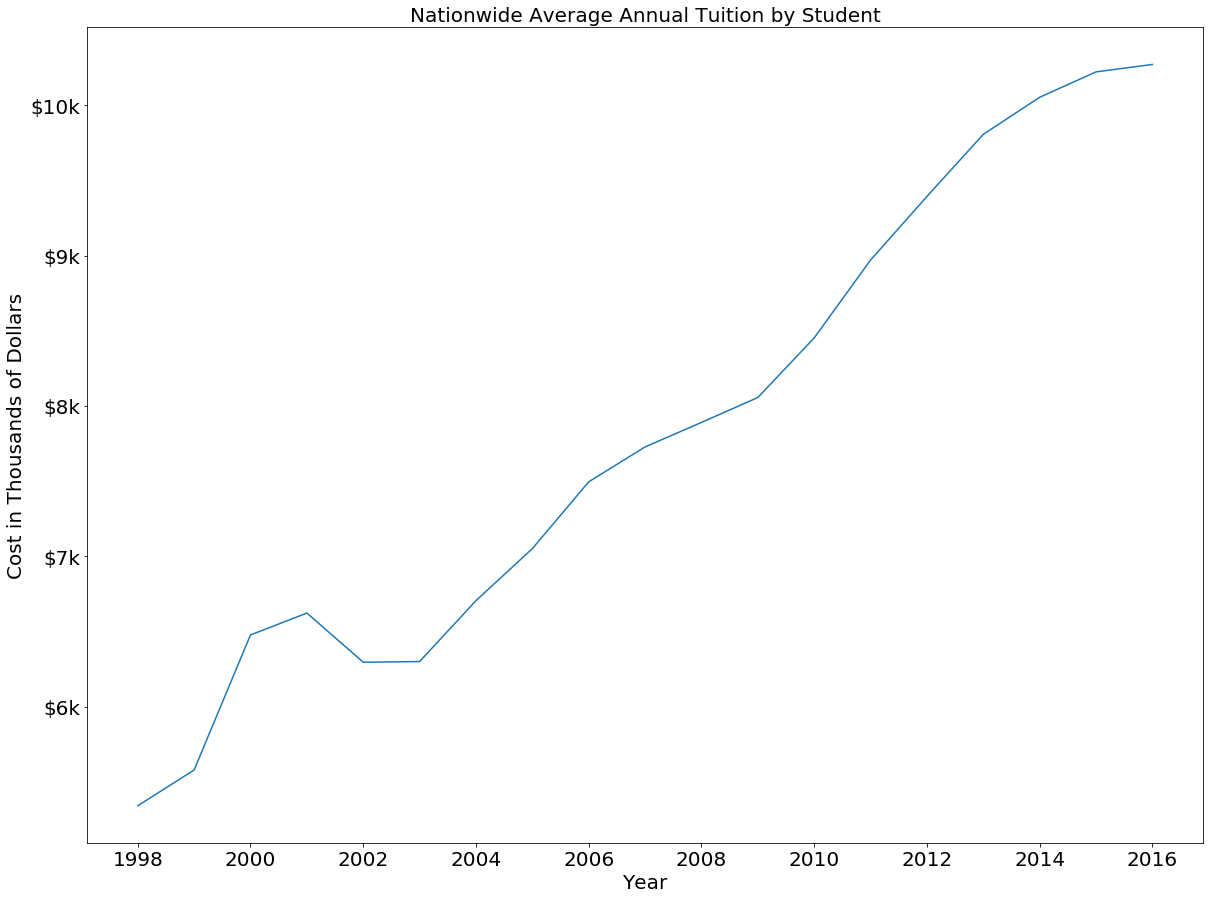

In [92]:
# plotting it again to make sure it's the same still
fig = plt.figure(figsize=(20,15))
plt.title('Nationwide Average Annual Tuition by Student', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Cost in Thousands of Dollars', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([6000, 7000, 8000, 9000, 10000], ['$6k', '$7k', '$8k', '$9k', '$10k'], fontsize=20)
plt.plot(tuition_time_series_df.index, tuition_time_series_data.values.ravel())
plt.savefig('Avg_annual_tuition_vs_year.png')

In [93]:
# Dickey-Fuller Test for stationarity
def dicky_fuller(y_series):
    '''
    returns dataframe with statistical results of dickey-fuller test and prints true or false values
    regarding the p-value at which the data is stationary. For example, 1% Stationary: True means that 
    your y_array is under a p-value of 1% and you can reject the null hypothesis that the y_array is NOT
    stationary.
    
    parameters:
    - y_series is a numpy array containing the data you would like to check stationarity for
    
    - Will probably want to add more like lags... will do later
    '''
    # Test requires no na or inf values. Converting to series to drop na
    y_series = pd.Series(y_series).dropna()
    y_series = np.array(y_series)
    
    # Running test
    dftest = adfuller(y_series)
    
    # Creating dataframe
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    # Add statistics to dataframe
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    # Create variables to print test statistics because it won't let me print otherwise for some reason
    test_statistic = dfoutput['Test Statistic']
    ten_percent = dfoutput['Critical Value (10%)']
    five_percent = dfoutput['Critical Value (5%)']
    one_percent = dfoutput['Critical Value (1%)']

    # Print
    print(f'1% Stationary: {test_statistic < one_percent}')
    print(f'5% Stationary: {test_statistic < five_percent}')
    print(f'10% Stationary: {test_statistic < ten_percent}')
    
    # return the dataframe
    return dfoutput

    

In [45]:
dicky_fuller(tuition_time_series_data.values.ravel())
# Not stationary

1% Stationary: False
5% Stationary: False
10% Stationary: False


Test Statistic                 -1.649369
p-value                         0.457370
#Lags Used                      7.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64

In [95]:
# making a rolling average
rolmean = pd.Series(avg_yearly_tuit).rolling(window=3).mean()

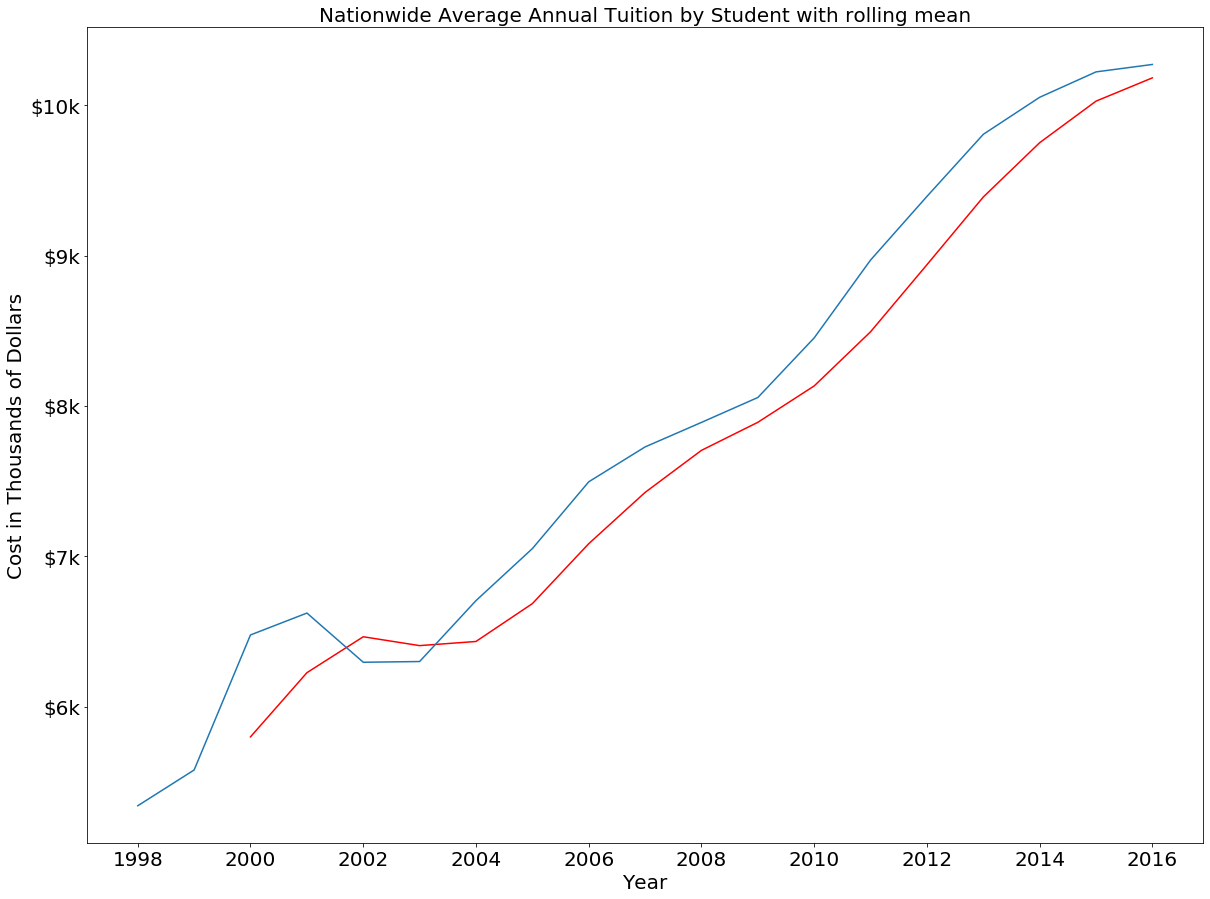

In [96]:
# Plotting rolling mean
fig = plt.figure(figsize=(20,15))
plt.title('Nationwide Average Annual Tuition by Student with rolling mean', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Cost in Thousands of Dollars', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([6000, 7000, 8000, 9000, 10000], ['$6k', '$7k', '$8k', '$9k', '$10k'], fontsize=20)
plt.plot(tuition_time_series_df.index, rolmean, color='red')
plt.plot(tuition_time_series_df.index, tuition_time_series_data.values.ravel())
plt.savefig('tuition_vs_year_with_rolling_mean.png')

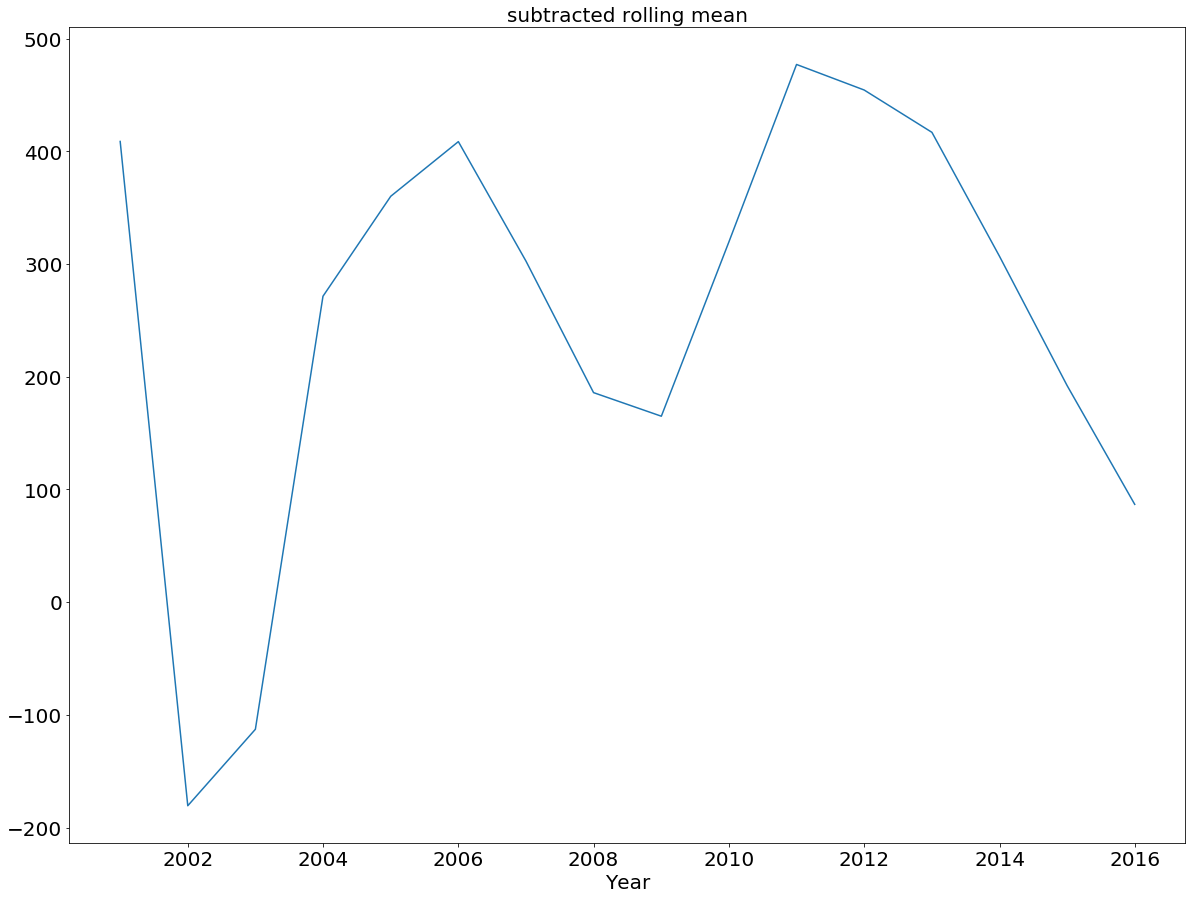

In [49]:
# Plotting stationary data
rolmean_diff = tuition_time_series_data.values.ravel()-rolmean

fig = plt.figure(figsize=(20,15))
plt.title('subtracted rolling mean', fontsize=20)
plt.xlabel('Year', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(tuition_time_series_df.index, rolmean_diff)
plt.savefig('stationary_timeseries.png')

In [50]:
dicky_fuller(rolmean_diff)
# Passes dicky fuller test

1% Stationary: True
5% Stationary: True
10% Stationary: True


Test Statistic                 -5.485628
p-value                         0.000002
#Lags Used                      1.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64

In [51]:
# Checking out weighted rolling mean
exp_rolmean = pd.Series(avg_yearly_tuit).ewm(halflife = 2).mean()

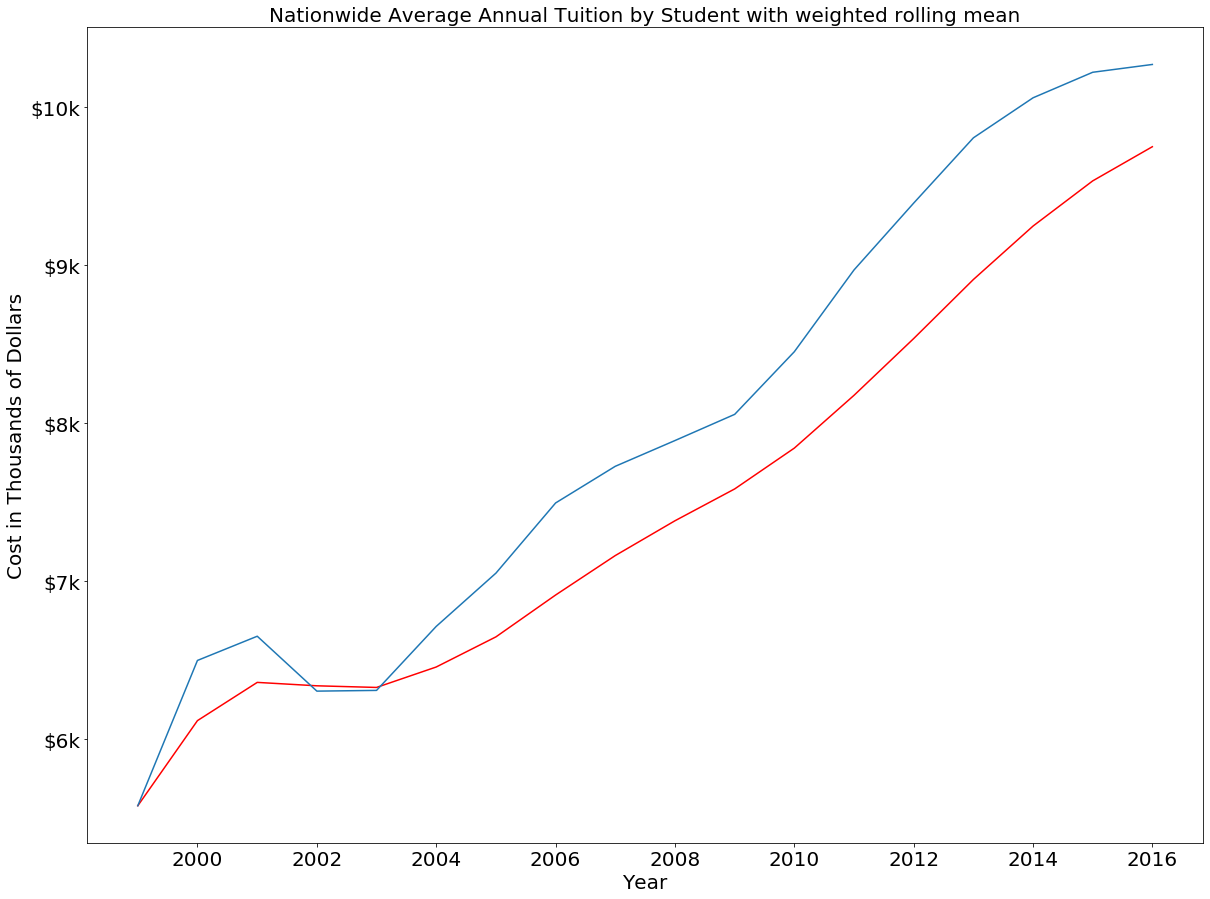

In [52]:
fig = plt.figure(figsize=(20,15))
plt.title('Nationwide Average Annual Tuition by Student with weighted rolling mean', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Cost in Thousands of Dollars', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([6000, 7000, 8000, 9000, 10000], ['$6k', '$7k', '$8k', '$9k', '$10k'], fontsize=20)
plt.plot(tuition_time_series_df.index, exp_rolmean, color='red')
plt.plot(tuition_time_series_df.index, tuition_time_series_data.values.ravel())

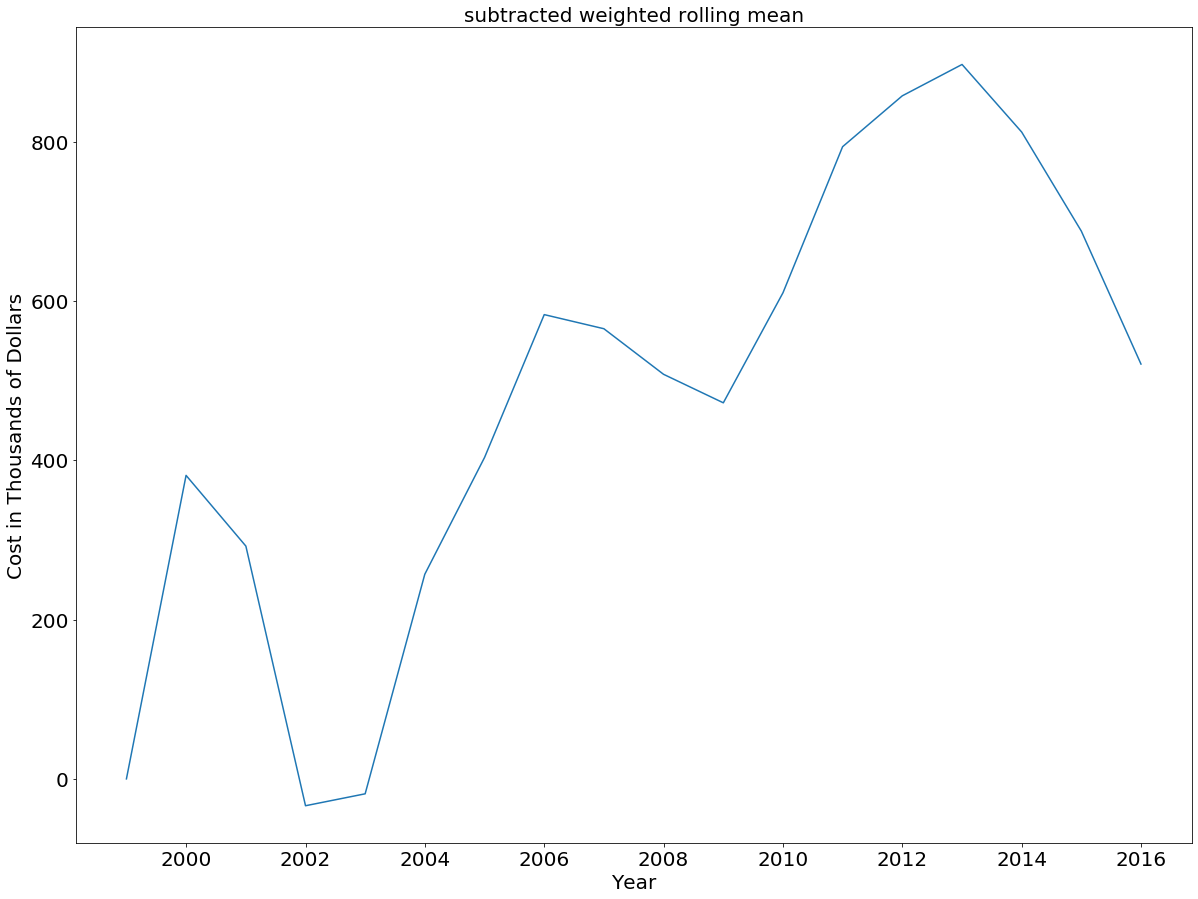

In [53]:
weighted_rolmean_diff = tuition_time_series_data.values.ravel()-exp_rolmean

fig = plt.figure(figsize=(20,15))
plt.title('subtracted weighted rolling mean', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Cost in Thousands of Dollars', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(tuition_time_series_df.index, weighted_rolmean_diff )

In [54]:
dicky_fuller(weighted_rolmean_diff)
# does NOT pass dicky fuller

1% Stationary: False
5% Stationary: False
10% Stationary: False


Test Statistic                 -0.491887
p-value                         0.893590
#Lags Used                      7.000000
Number of Observations Used    10.000000
Critical Value (1%)            -4.331573
Critical Value (5%)            -3.232950
Critical Value (10%)           -2.748700
dtype: float64

In [55]:
# Trying differencing to see if it will remove seasonality trends
tuit_diff = tuition_time_series_data.diff(periods=1)

In [56]:
tuit_diff

year
1999           NaN
2000    919.638211
2001    153.273229
2002   -347.484627
2003      4.615134
2004    404.789543
2005    337.751719
2006    443.960681
2007    231.926396
2008    162.887825
2009    166.021414
2010    396.519601
2011    517.258389
2012    422.907083
2013    413.745561
2014    253.311650
2015    161.546447
2016     49.406526
Name: TUITFTE, dtype: float64

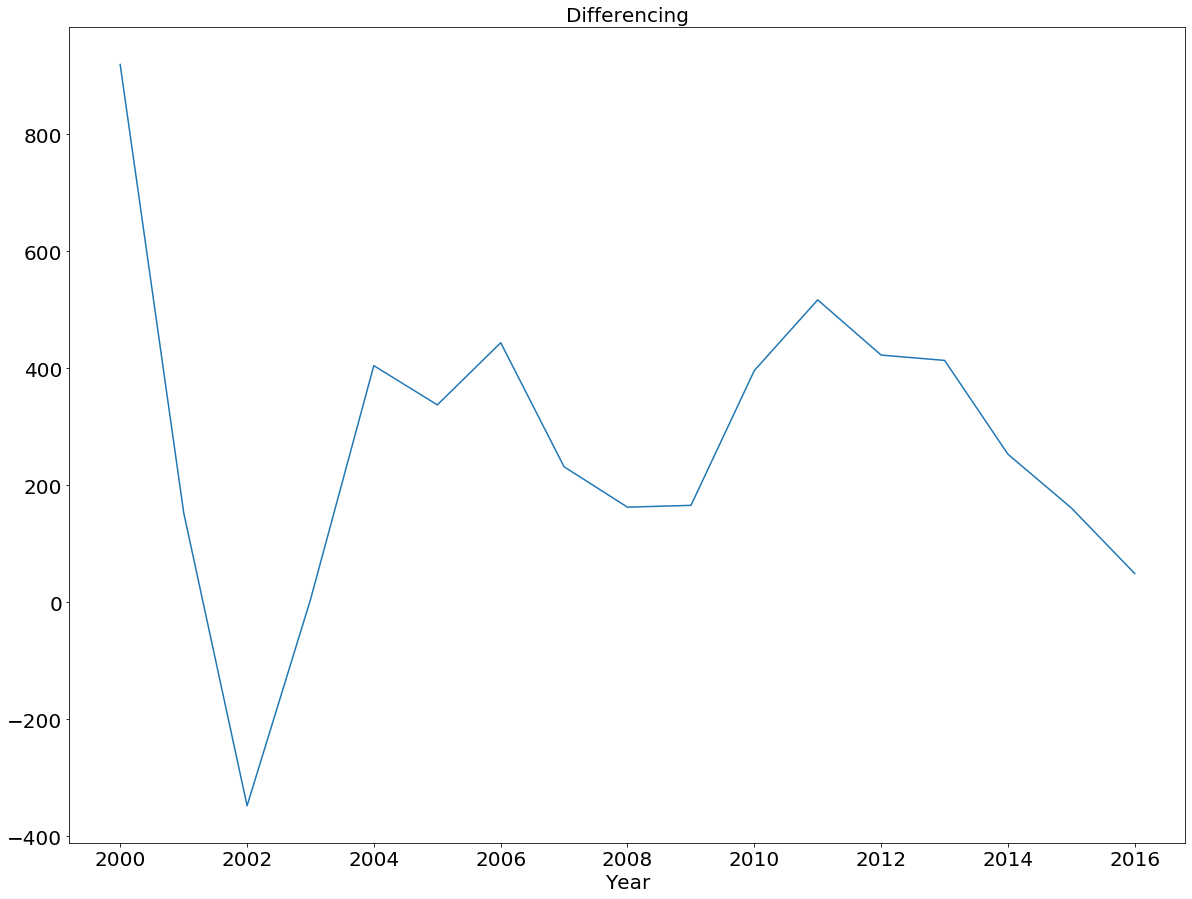

In [57]:
fig = plt.figure(figsize=(20,15))
plt.title('Differencing', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(tuition_time_series_df.index, tuit_diff)

In [58]:
dicky_fuller(tuit_diff)
# Works but not as well as just subtracting the rolling mean

1% Stationary: False
5% Stationary: True
10% Stationary: True


Test Statistic                 -3.163811
p-value                         0.022177
#Lags Used                      2.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64

In [59]:
# Making a dataframe to review all results
tuition_time_series_data.index = pd.to_datetime(tuition_time_series_data.index, format='%Y')
tuition_time_series_data = pd.DataFrame(tuition_time_series_data)

tuition_time_series_data['rolmean_diff'] = rolmean_diff.values
tuition_time_series_data['weighted_rolmean_diff'] = weighted_rolmean_diff.values
tuition_time_series_data['tuit_diff'] = tuit_diff.values
tuition_time_series_data

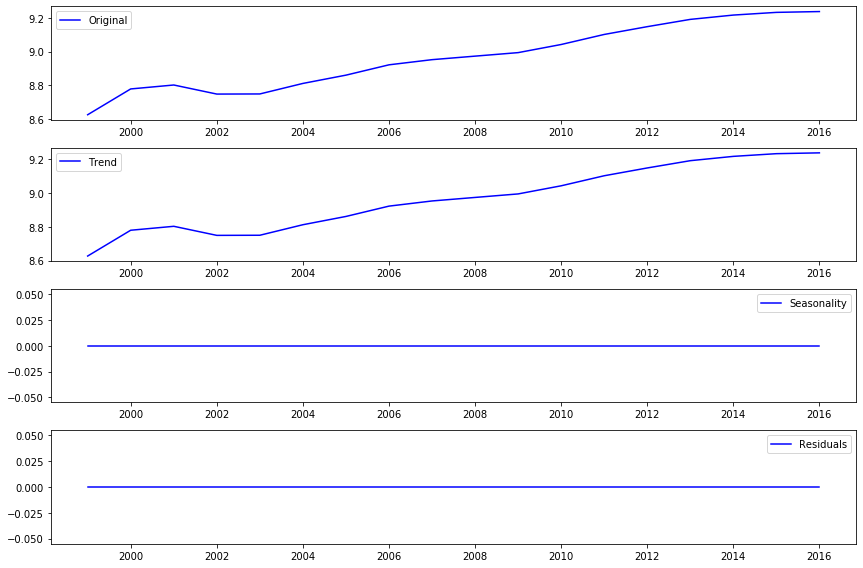

In [61]:
# Checking out seasonal_decompose to decompose a 4th time
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(tuition_time_series_data['TUITFTE']))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# # Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(tuition_time_series_data['TUITFTE']), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

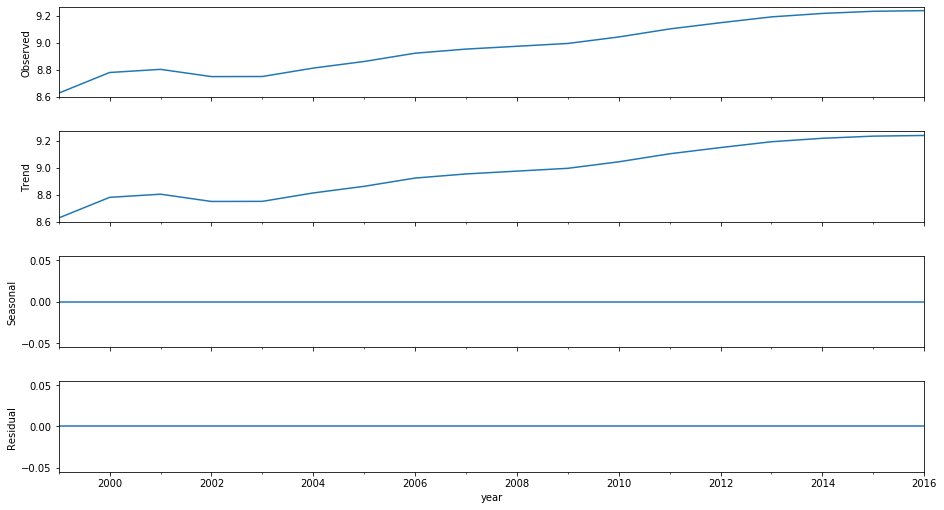

In [62]:
# This is a way better way to write the previous cell. Does the same exact thing
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(tuition_time_series_data['TUITFTE']))
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

# Ok.
Guess there's just a trend and not much else...

In [63]:
tuition_time_series_data

,TUITFTE,rolmean_diff,weighted_rolmean_diff,tuit_diff
year,,,,
1999-01-01,5580.027293,NaN,0.000000,NaN
2000-01-01,6499.665504,NaN,380.926620,919.638211
2001-01-01,6652.938732,408.728223,292.163598,153.273229
2002-01-01,6305.454106,-180.565342,-33.716823,-347.484627
2003-01-01,6310.069239,-112.751453,-18.747649,4.615134
2004-01-01,6714.858782,271.398073,256.820119,404.789543
2005-01-01,7052.610502,360.097661,403.540867,337.751719
2006-01-01,7496.571183,408.557694,582.725595,443.960681
2007-01-01,7728.497579,302.604491,565.013374,231.926396


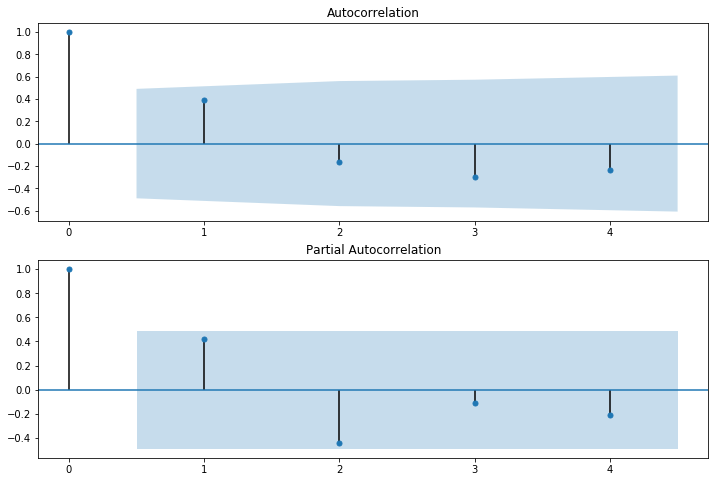

In [64]:
# Autocorrelation and Partial autocorrelation plots

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(tuition_time_series_data['rolmean_diff'].values[2:], ax=ax1, lags =4)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(tuition_time_series_data['rolmean_diff'].values[2:], ax=ax2, lags=4)

plt.savefig('autocorrelation.png')

In [65]:
# ARIMA for ten year tuition prediction

from statsmodels.tsa.arima_model import ARMA
from random import random
# contrived dataset
data = tuition_time_series_data['rolmean_diff'][2:]
# fit model
model = ARMA(data, order=(1, 0))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data)-1, len(data)+10)
print(yhat)

2016-01-01    228.695238
2017-01-01    186.184481
2018-01-01    226.294112
2019-01-01    242.479375
2020-01-01    249.010544
2021-01-01    251.646037
2022-01-01    252.709527
2023-01-01    253.138672
2024-01-01    253.311843
2025-01-01    253.381722
2026-01-01    253.409920
2027-01-01    253.421298
Freq: AS-JAN, dtype: float64


/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 <a list of 8 Text yticklabel objects>)

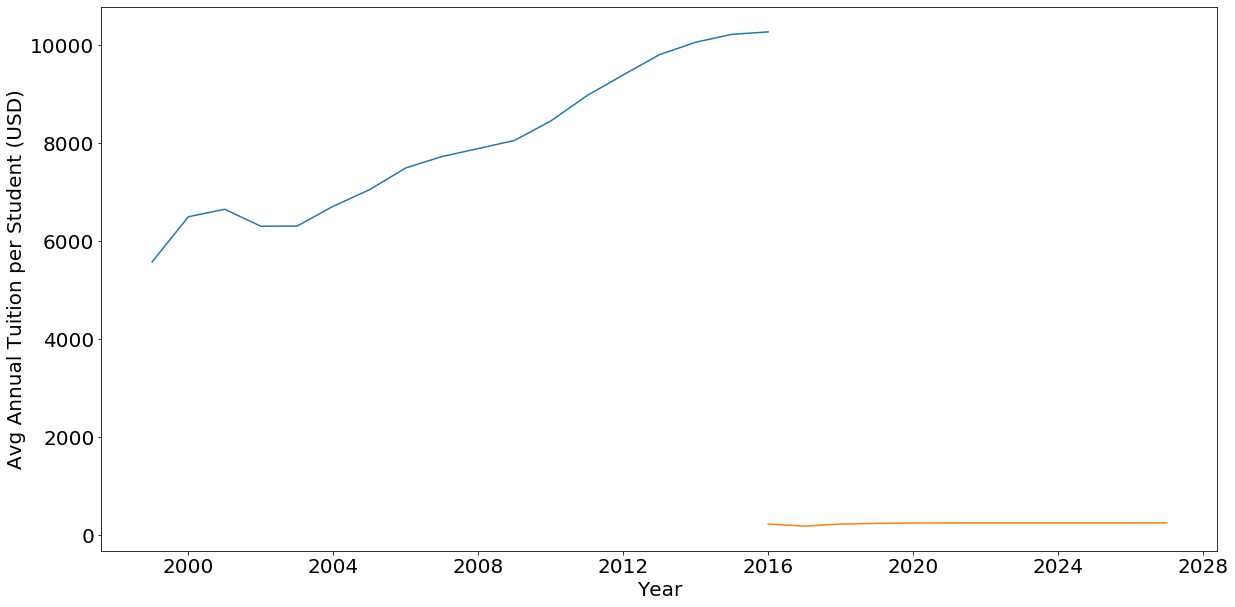

In [66]:
# Plotting ARIMA
plt.figure(figsize=(20,10))
plt.plot(tuition_time_series_data.index, tuition_time_series_data['TUITFTE'].values)
plt.plot(yhat.index, yhat.values)
plt.xlabel('Year', fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Avg Annual Tuition per Student (USD)', fontsize=20)
plt.yticks(fontsize=20)

In [67]:
# Need to add back in the rolling mean
fixed_pred = list(tuition_time_series_data['TUITFTE'].values)
w_moving_avg = tuition_time_series_data['TUITFTE'].values[-3:].mean() + yhat[0]
fixed_pred.append(w_moving_avg)


In [68]:
tuition_time_series_data

,TUITFTE,rolmean_diff,weighted_rolmean_diff,tuit_diff
year,,,,
1999-01-01,5580.027293,NaN,0.000000,NaN
2000-01-01,6499.665504,NaN,380.926620,919.638211
2001-01-01,6652.938732,408.728223,292.163598,153.273229
2002-01-01,6305.454106,-180.565342,-33.716823,-347.484627
2003-01-01,6310.069239,-112.751453,-18.747649,4.615134
2004-01-01,6714.858782,271.398073,256.820119,404.789543
2005-01-01,7052.610502,360.097661,403.540867,337.751719
2006-01-01,7496.571183,408.557694,582.725595,443.960681
2007-01-01,7728.497579,302.604491,565.013374,231.926396


In [70]:
for i in range(1, len(yhat)):
    w_moving_avg = np.mean(fixed_pred[-3:]) + yhat.values[i]
    fixed_pred.append(w_moving_avg)

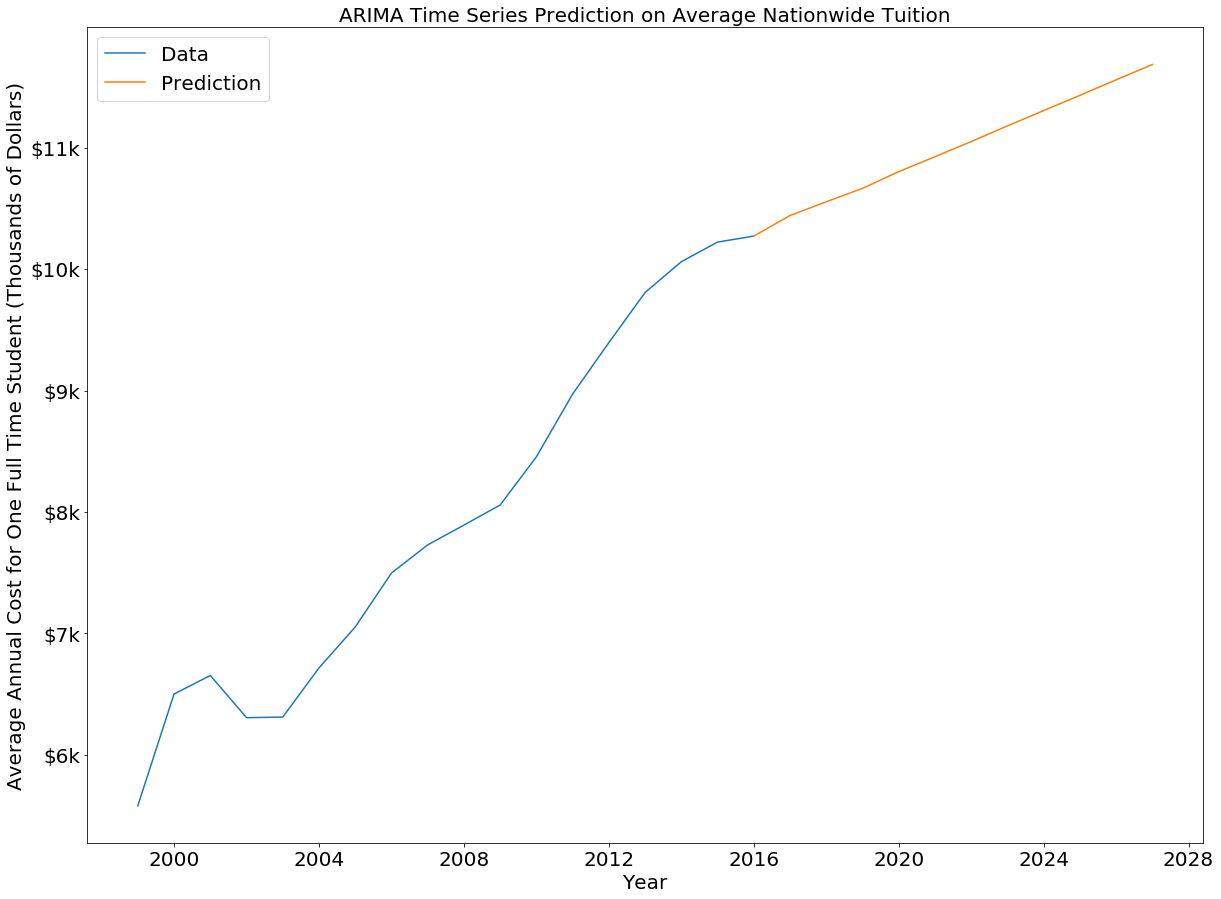

In [71]:
# Plotting ARIMA with rolling mean
plt.figure(figsize=(20,15))
plt.title('ARIMA Time Series Prediction on Average Nationwide Tuition', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([6000, 7000, 8000, 9000, 10000, 11000, 12000], ['$6k', '$7k', '$8k', '$9k', '$10k', '$11k', '$12k'], fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Average Annual Cost for One Full Time Student (Thousands of Dollars)', fontsize=20)
#plt.text(2026,11000, '2028 Tuition Pred: ~$11700')
plt.plot(tuition_time_series_data.index[:2016], fixed_pred[:len(tuition_time_series_data)], label='Data')
plt.plot(yhat.index, fixed_pred[(len(tuition_time_series_data)):], label='Prediction')
plt.legend(loc='upper left', fontsize=20)
plt.savefig('ten_year_prediction.png')

In [72]:
# Ten year prediction
fixed_pred[-1]

11685.792706489023